In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import numpy as np
import pandas as pd
import random
from skimage import io
import os
from glob import glob

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
augmenters = {
    'Perspective': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
        ]),
                                       
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
}

In [ ]:
class Picture_Dataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/drive/MyDrive/dataset')
#TEST_DIR = Path('/test')
#test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

frames_f = [Path('drive/MyDrive/dataset/klikun/images/' + i) for i in os.listdir(os.path.join(TRAIN_DIR, 'klikun/images'))]
frames_f.extend([Path('drive/MyDrive/dataset/maliy/images/' + i) for i in os.listdir(os.path.join(TRAIN_DIR, 'maliy/images'))])
frames_f.extend([Path('drive/MyDrive/dataset/shipun/images/' + i) for i in os.listdir(os.path.join(TRAIN_DIR, 'shipun/images'))])

train_val_files = frames_f

In [ ]:
len(train_val_files)

9038

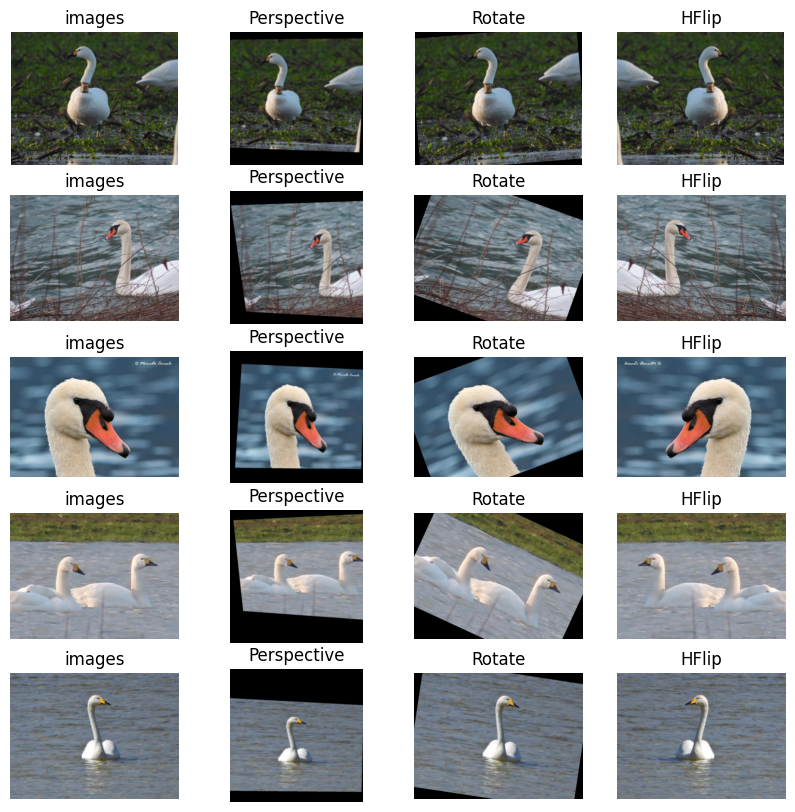

In [ ]:
train_dataset = Picture_Dataset(train_val_files, mode='train')

fig, ax = plt.subplots(nrows=5, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(5):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = train_dataset.load_sample(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name
    
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

In [ ]:
import os

create_dir = Path('/content/drive/MyDrive/sample')

if not os.path.isdir(create_dir):
    os.mkdir(create_dir)

proc_dataset = Picture_Dataset(train_files, mode='train')

for image_path in tqdm(train_files):
    path = image_path.parents[1]
    character = image_path.parent.parent.name
    img = proc_dataset.load_sample(image_path)
    
    for i in range(int(3)):
        
        parent_dir = Path('/content/drive/MyDrive/sample')
        
        directory = character
        
        path = os.path.join(parent_dir, directory, 'image')
        
        if not os.path.isdir(path):
            os.mkdir(path)
        
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

  0%|          | 11/8134 [00:05<1:06:39,  2.03it/s]


KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.10, stratify=train_val_labels, random_state=111)

val_dataset = Picture_Dataset(val_files, mode='val')

print(len(train_files), len(val_files))

8134 904


In [ ]:
train_dataset = Picture_Dataset(train_files, mode='train')

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)
#model.eval()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.classifier = nn.Linear(in_features=960, out_features=3, bias=True)


# Tuned Alexnet

In [ ]:
class AlexNetV1(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.ln1 = nn.Sequential(
            nn.Linear(128 * 5 * 5, 4096),
            nn.BatchNorm1d(4096),
            nn.Dropout(p=0.05),
            nn.LeakyReLU(),
        )
        self.ln2 = nn.Sequential(
            nn.Linear(4096, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.05),
            nn.LeakyReLU(),
        )
        self.ln3 = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.out = nn.Linear(128, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(x.size(0), -1)
        
        x=self.ln1(x)
        x=self.ln2(x)
        x=self.ln3(x)
        
        logits = self.out(x)
        
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=7e-4, betas=(0.9, 0.99)) #добавлено для оптимизации
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            torch.save(model.state_dict(), SAVE_W_PATH + f'model_weights_{epoch}.pth')
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = model.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)
print(np.unique(train_val_labels))

we will classify :3
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1

In [ ]:
if val_dataset is None:
    val_dataset = Picture_Dataset(val_files, mode='val')
    
if train_dataset is None:
    train_dataset = Picture_Dataset(train_files, mode='train')

SAVE_W_PATH = '/content/drive/MyDrive/'

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=3, batch_size=128)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.38730058179884774


epoch:  33%|███▎      | 1/3 [06:00<12:01, 360.86s/it]


Epoch 001 train_loss: 0.3873     val_loss 0.6716 train_acc 0.8361 val_acc 0.8219
loss 0.3011735995051197


epoch:  67%|██████▋   | 2/3 [11:59<05:59, 359.55s/it]


Epoch 002 train_loss: 0.3012     val_loss 0.2034 train_acc 0.8868 val_acc 0.9192
loss 0.14464833646213976


epoch: 100%|██████████| 3/3 [17:48<00:00, 356.17s/it]


Epoch 003 train_loss: 0.1446     val_loss 0.2120 train_acc 0.9465 val_acc 0.9237


In [ ]:
history += train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=128)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 0.12797857086303113


epoch:  25%|██▌       | 1/4 [05:50<17:30, 350.15s/it]


Epoch 001 train_loss: 0.1280     val_loss 0.1975 train_acc 0.9600 val_acc 0.9369
loss 0.04633148066435703


epoch:  50%|█████     | 2/4 [11:34<11:33, 346.52s/it]


Epoch 002 train_loss: 0.0463     val_loss 0.1969 train_acc 0.9834 val_acc 0.9192
loss 0.04474640395634292


epoch:  75%|███████▌  | 3/4 [17:17<05:45, 345.02s/it]


Epoch 003 train_loss: 0.0447     val_loss 0.1979 train_acc 0.9839 val_acc 0.9259
loss 0.03407804418299352


epoch: 100%|██████████| 4/4 [23:09<00:00, 347.46s/it]


Epoch 004 train_loss: 0.0341     val_loss 0.3324 train_acc 0.9882 val_acc 0.9259


In [80]:
torch.save(simple_cnn.state_dict(), '/content/drive/MyDrive/mobile_netv3.pth')

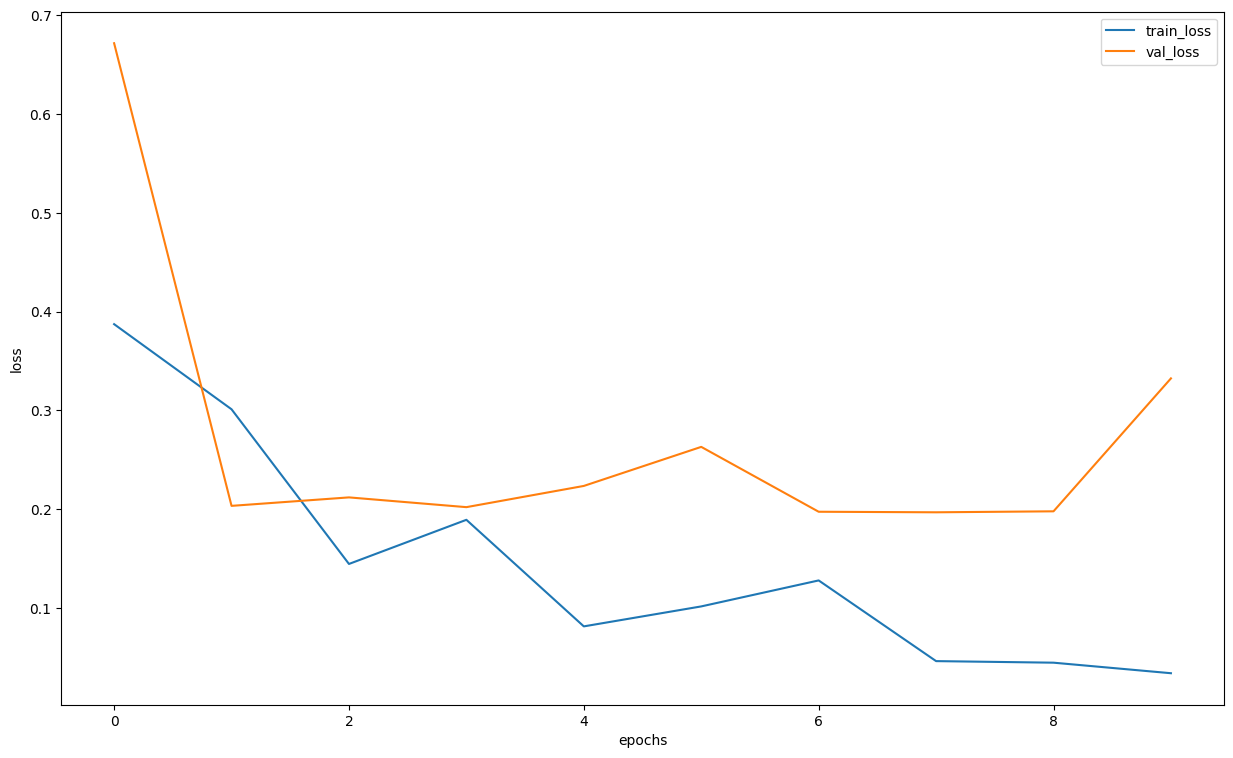

In [81]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [83]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 300)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

RuntimeError: ignored

In [84]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

NameError: ignored

RuntimeError: ignored

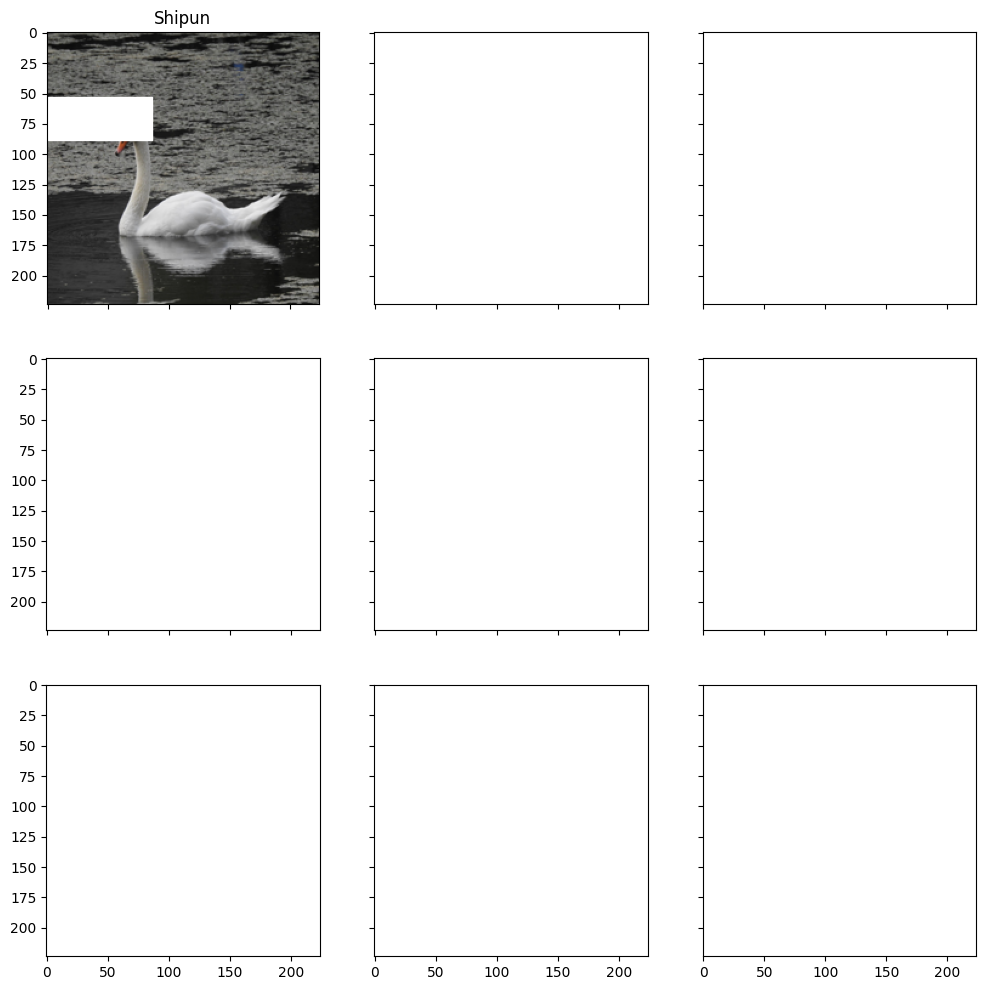

In [85]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [86]:
test_dataset = Picture_Dataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

NameError: ignored

In [87]:
import pandas as pd

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

NameError: ignored

In [88]:
my_submit.to_csv('submission.csv', index=False)

NameError: ignored